In [1]:
# Dataset - https://www.kaggle.com/datasets/jangedoo/utkface-new
# go to your profile
# Go to accounts
# click on create new api token - a jason file will be download
# Upload that file in google-colab
# run two command prefetch jason file
# download datasets command

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:15<00:00, 23.5MB/s]
100% 331M/331M [00:15<00:00, 22.5MB/s]


In [4]:
# Extract data from zip file
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [6]:
# Folder path
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [7]:
# Applying split operation to extract age, gender
# In the bellow list 1st valu is age and 2nd value is gender
os.listdir(folder_path)[0].split('_')

['9', '0', '0', '20170120133317677.jpg.chip.jpg']

In [8]:
age = []
gender = []
img_path = []

for file in os.listdir(folder_path):
  img_path.append(file)
  file_split = file.split('_')
  age.append(int(file_split[0]))
  gender.append(int(file_split[1]))
  

This code extract all the data from file.

In [9]:
len(age)

23708

In [10]:
age[0]

9

In [11]:
gender[0]

0

In [12]:
img_path[0]

'9_0_0_20170120133317677.jpg.chip.jpg'

In [13]:
# Make an dataframe to convert two output value
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [14]:
df.shape

(23708, 3)

In [15]:
df.head()

,age,gender,img
0,9,0,9_0_0_20170120133317677.jpg.chip.jpg
1,28,1,28_1_0_20170116205749382.jpg.chip.jpg
2,85,1,85_1_3_20170110183103000.jpg.chip.jpg
3,65,0,65_0_0_20170120224023991.jpg.chip.jpg
4,27,1,27_1_2_20170116165450739.jpg.chip.jpg


In [16]:
#Split the data randomly into train, test
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [17]:
test_df

,age,gender,img
9293,1,1,1_1_4_20161221201957481.jpg.chip.jpg
7515,28,0,28_0_2_20170116190154379.jpg.chip.jpg
53,26,0,26_0_0_20170120134406935.jpg.chip.jpg
6395,53,0,53_0_0_20170120223146786.jpg.chip.jpg
21250,68,1,68_1_1_20170110183842657.jpg.chip.jpg
...,...,...,...
13123,16,1,16_1_0_20170105000748206.jpg.chip.jpg
19648,32,1,32_1_1_20170116012153835.jpg.chip.jpg
9845,55,0,55_0_3_20170117155001317.jpg.chip.jpg
10799,29,0,29_0_0_20170116221002399.jpg.chip.jpg


In [18]:
# Creating Image augmention generator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
# Applying Image augmention generator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(224,224),
                                                    class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(224,224),
                                                  class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [20]:
from keras.applications.resnet_v2 import ResNet50V2
from keras.layers import *
from keras.models import Model

In [21]:
# Applying transfer learning using resnet50V2
resnet = ResNet50V2(include_top=False, input_shape=(224,224,3))

94668760/94668760 [==============================] - 5s 0us/step


In [22]:
# Creating an Functional api
# Trainable parameter are false
resnet.trainable=False

# Creating functinal api using transfer learning upto resnet model output layer
output = resnet.layers[-1].output

# Flatten the output of resnet module
flatten = Flatten()(output)

# Creating Fully connected layer for age and gender
dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

# Creating anaother Fully connected layer for age and gender
dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

# Creating two output layer
output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [23]:
# Building our Functional api model for two output
model = Model(inputs=resnet.input,outputs=[output1,output2])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

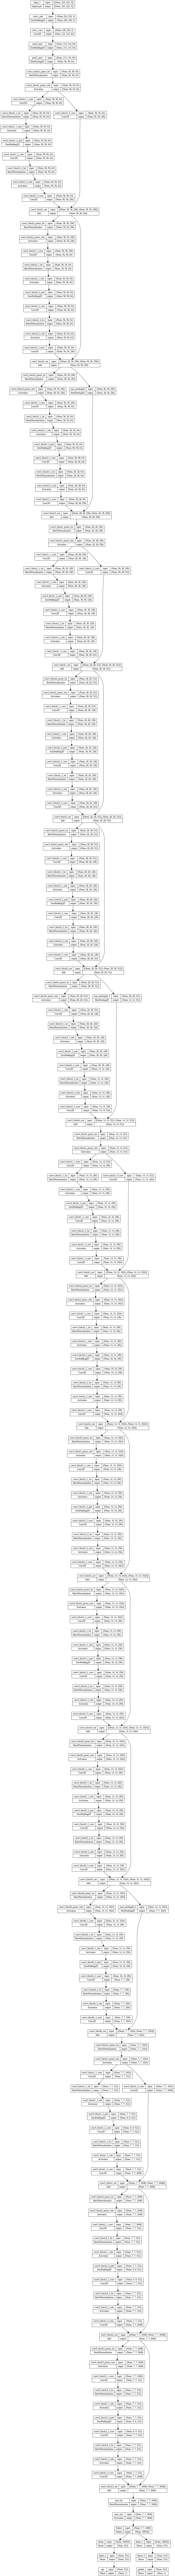

In [24]:
# Plotting out model
from keras.utils import plot_model
plot_model(model,show_shapes=1)

In [25]:
# compile our model like sequential model for two output and its metrics
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [27]:
# fit the model with input data
history = model.fit(train_generator, batch_size=32, epochs=10, validation_data=test_generator)

Epoch 1/10
625/625 [==============================] - 255s 407ms/step - loss: 54.7410 - age_loss: 9.0799 - gender_loss: 0.4612 - age_mae: 9.0799 - gender_accuracy: 0.7861 - val_loss: 42.8043 - val_age_loss: 8.2404 - val_gender_loss: 0.3491 - val_age_mae: 8.2404 - val_gender_accuracy: 0.8474
Epoch 2/10
625/625 [==============================] - 260s 416ms/step - loss: 48.4510 - age_loss: 8.4780 - gender_loss: 0.4038 - age_mae: 8.4780 - gender_accuracy: 0.8124 - val_loss: 40.9340 - val_age_loss: 7.7094 - val_gender_loss: 0.3356 - val_age_mae: 7.7094 - val_gender_accuracy: 0.8525
Epoch 3/10
625/625 [==============================] - 252s 403ms/step - loss: 46.2722 - age_loss: 8.0434 - gender_loss: 0.3861 - age_mae: 8.0434 - gender_accuracy: 0.8233 - val_loss: 39.2350 - val_age_loss: 7.4897 - val_gender_loss: 0.3207 - val_age_mae: 7.4897 - val_gender_accuracy: 0.8598
Epoch 4/10
625/625 [==============================] - 251s 401ms/step - loss: 45.3060 - age_loss: 7.9314 - gender_loss: 0.37

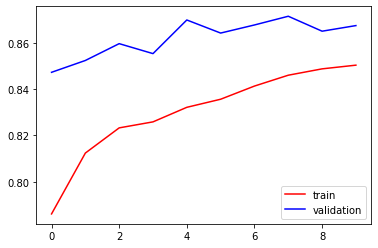

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history['gender_accuracy'],color='red',label='train')
plt.plot(history.history['val_gender_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

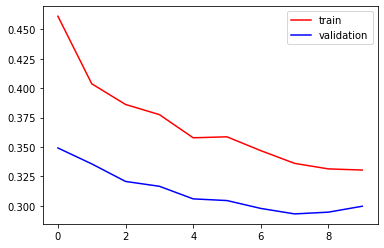

In [32]:
plt.plot(history.history['gender_loss'],color='red',label='train')
plt.plot(history.history['val_gender_loss'],color='blue',label='validation')
plt.legend()
plt.show()

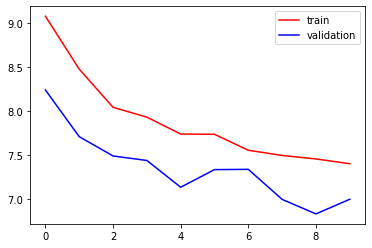

In [33]:
plt.plot(history.history['age_mae'],color='red',label='train')
plt.plot(history.history['val_age_mae'],color='blue',label='validation')
plt.legend()
plt.show()

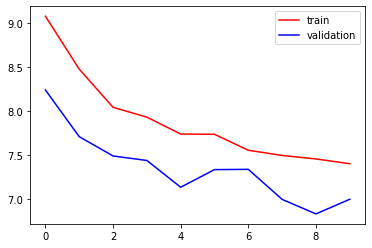

In [34]:
plt.plot(history.history['age_loss'],color='red',label='train')
plt.plot(history.history['val_age_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# https://machinelearningmastery.com/keras-functional-api-deep-learning/